In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import pytorch_lightning as pl
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.fftpack import fft, dct

from argparse import Namespace
from tqdm.notebook import tqdm

from IPython.display import Audio

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


(16000, 1)
8000


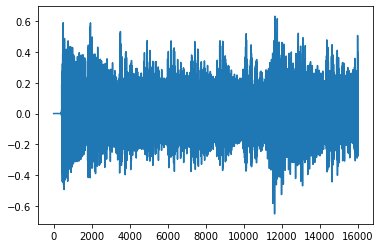

In [3]:
# audio_file = '../data/violin_violin.mp3'
audio_file = '../data/piano.wav'
x, fs = librosa.load(audio_file, sr=8000, offset=0.5, duration=2)
x = x[:,None]
print(x.shape)
print(fs)

plt.plot(x)
plt.show()

In [4]:
Audio(x[:,0], rate=fs)

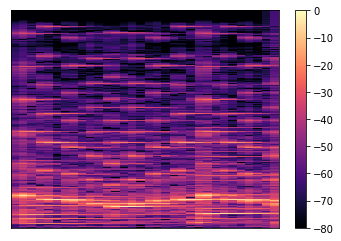

In [5]:
D = librosa.stft(x[:,0])  # STFT of x
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()

(16000, 1)


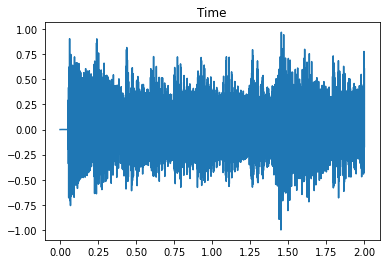

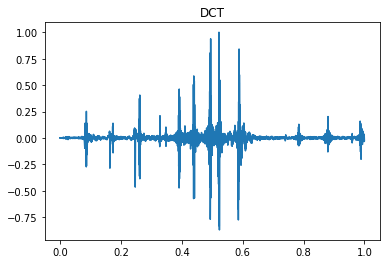

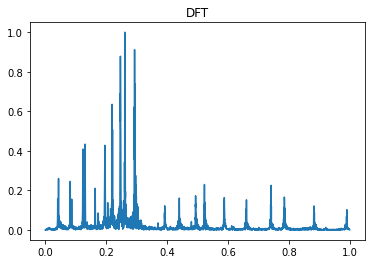

In [6]:
# to mono
x = x - np.mean(x, axis=0)

dur = 3

x = x[int(0*fs):int((0+dur)*fs)]
x = x / np.max(np.abs(x))
t = np.arange(0,len(x))/fs
t = t[:,None]
print(x.shape)

plt.title('Time')
plt.plot(t, x)
plt.show()


Xs = dct(x, axis=0)[:len(x)//4]
Xs = Xs/np.max(np.abs(Xs))
s = np.linspace(0,1,len(Xs))
plt.title('DCT')
plt.plot(s, Xs)
plt.show()


Xf = fft(x, axis=0)[:len(x)//4]
Xf = Xf/np.max(np.abs(Xf))
f = np.linspace(0,1,len(Xf))
plt.title('DFT')
plt.plot(f, np.abs(Xf))
plt.show()

In [7]:
class CurrDataset(torch.utils.data.Dataset):

    def __init__(self, t, x, device):
        super(CurrDataset, self).__init__()

        self.x = torch.from_numpy(x).float().to(device)
        self.t = torch.from_numpy(t).float().to(device)
        assert x.shape == t.shape
        self.size = x.shape[0]

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        t = self.t[idx,:]
        x = self.x[idx,:]
        return t, x

dataset = CurrDataset(t, x, device)
invar, outvar = dataset[:]

# plt.plot(invar, outvar)
# plt.show()

In [8]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=666, shuffle=True)
from recipes.audio.model import MFN

data_max_freqs = [1000, 2000, 4000]
model = MFN(in_dim=1, hidden_dim=32, out_dim=1, k=3, filter_fun='Gabor', data_max_freq=data_max_freqs)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

#initialize empty list to track batch losses
batch_losses = []

#train the neural network for 5 epochs
for epoch in tqdm(range(1000)):

    #reset iterator
    batch = iter(dataloader)
    
    for invar, outvar in batch:
                
        #forward propagation through the network        
        #reset gradients
        optimizer.zero_grad()

        outvar_pred = model(invar)
        loss = torch.mean(torch.abs(outvar_pred - outvar)**2)
        
        #track batch loss
        batch_losses.append(loss.item())

        #backpropagation
        loss.backward()

        #update the parameters
        optimizer.step()
    
    if epoch % 20 == 0:
        scheduler.step()
        
        
    if epoch % 100 == 0:
        print(batch_losses[-1])
        
    if batch_losses[-1] < 1e-4:
        break

torch.save(model.state_dict(), './model.ptc')

  0%|          | 0/1000 [00:00<?, ?it/s]

0.07631363719701767
0.006996870040893555
0.006680263672024012
0.00774197094142437
0.0069435955956578255
0.005002977326512337
0.004310349002480507
0.008128806948661804
0.004531484562903643
0.007386156357824802


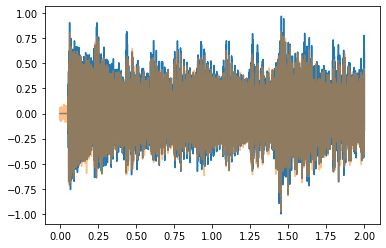

In [9]:
invar, outvar = dataset[:]

plt.plot(invar.cpu(), outvar.cpu())

pred = model(invar)
plt.plot(invar.cpu(), pred.cpu().detach(), alpha=0.5)
plt.show()

Audio(pred[:,0].detach().cpu(), rate=fs)

In [10]:
print(model)

MFN(
  (filters): ModuleList(
    (0): GaborFilter(
      (linear): Linear(in_features=1, out_features=32, bias=True)
    )
    (1): GaborFilter(
      (linear): Linear(in_features=1, out_features=32, bias=True)
    )
    (2): GaborFilter(
      (linear): Linear(in_features=1, out_features=32, bias=True)
    )
  )
  (linear): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [11]:
model.eval()
x = invar
g0 = model.filters[0](x)
g1 = model.filters[1](x)
g2 = model.filters[2](x)

z0 = g0
z1 = model.linear[0](z0)*g1
z2 = model.linear[1](z1)*g2
z3 = model.linear[2](z2)
y = model(x)

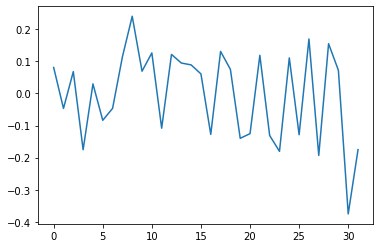

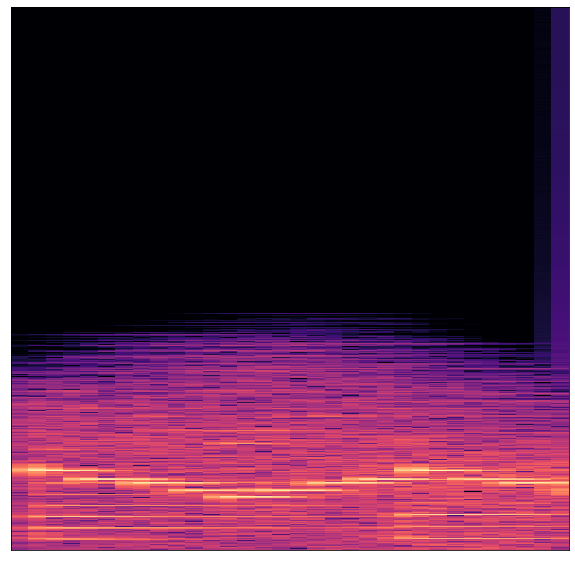

In [12]:
out = z2.detach().cpu().numpy()
out = np.sum(out[:,:],1)

w2 = model.linear[2].weight.data
b2 = model.linear[2].bias.data

plt.plot(w2.squeeze().detach().cpu().numpy())
plt.show()

out = b2 + z2[:,:]@w2[:,:].T
out = out.detach().cpu().numpy()
out = np.sum(out[:,:],1)



D = librosa.stft(out)  # STFT of x
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(10,10))
librosa.display.specshow(S_db)
plt.show()

Audio(out, rate=fs)

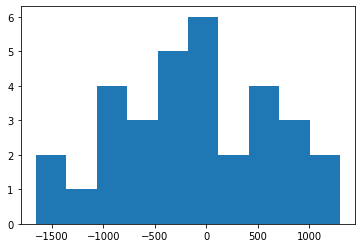

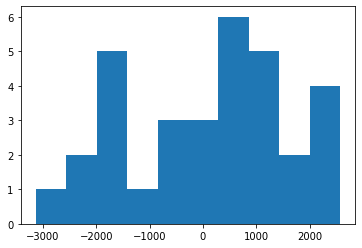

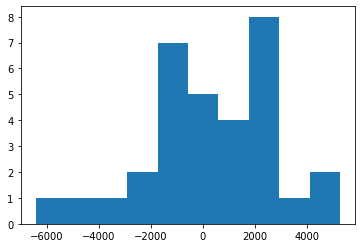

In [13]:
for k in range(3):
    freqs = model.filters[k].linear.weight.data.detach().cpu().numpy()
    plt.hist(freqs.squeeze())
    plt.show()

(32, 1)
(32,)
(32, 1)
(32, 32)


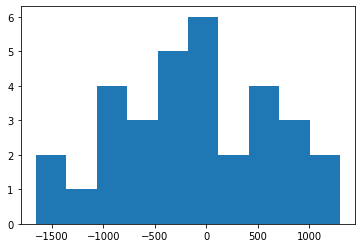

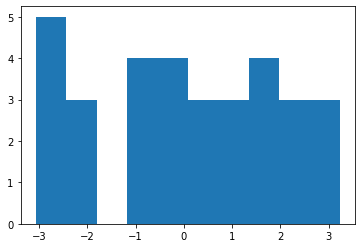

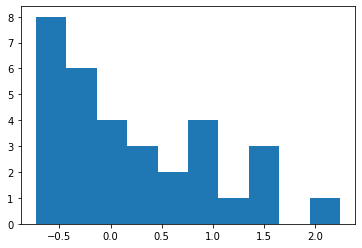

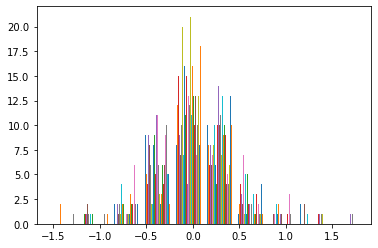

In [14]:
freqs1 = model.filters[0].linear.weight.data.detach().cpu().numpy()
phase1 = model.filters[0].linear.bias.data.detach().cpu().numpy()
loc1 =   model.filters[0].mu.data.detach().cpu().numpy()
coeff1 = model.linear[0].weight.data.detach().cpu().numpy()
print(freqs1.shape)
print(phase1.shape)
print(loc1.shape)
print(coeff1.shape)

plt.hist(freqs1[:,0])
plt.show()
plt.hist(phase1)
plt.show()
plt.hist(loc1[:,0])
plt.show()
plt.hist(coeff1)
plt.show()

torch.Size([16000, 32])


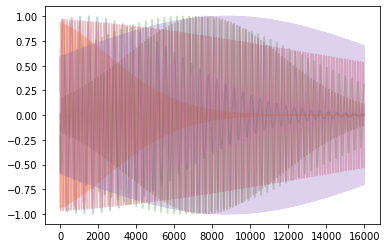

In [15]:
out = g0
print(out.shape)
idx = np.arange(0,32,5)
for i in idx:
    plt.plot(out[:,i].detach().cpu(), alpha=0.3)
plt.show()

Audio(torch.mean(out[:,idx].detach().cpu(), dim=1), rate=fs)

torch.Size([16000, 32])


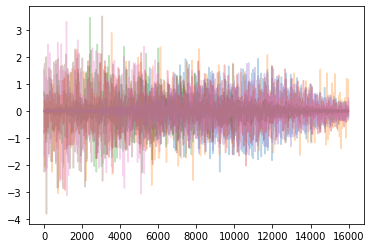

In [16]:
out = z1
print(out.shape)
idx = np.arange(0,32,5)
for i in idx:
    plt.plot(out[:,i].detach().cpu(), alpha=0.3)
plt.show()

Audio(torch.mean(out[:,idx].detach().cpu(), dim=1), rate=fs)

torch.Size([16000, 32])


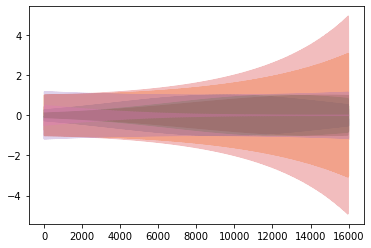

In [17]:
out = g2
print(out.shape)
idx = np.arange(0,32,5)
for i in idx:
    plt.plot(out[:,i].detach().cpu(), alpha=0.3)
plt.show()

Audio(torch.mean(out[:,idx].detach().cpu(), dim=1), rate=fs)

In [18]:
Audio(torch.mean(l2.detach().cpu(), dim=1), rate=fs)

NameError: name 'l2' is not defined

In [ ]:
Audio(torch.mean(z2.detach().cpu(), dim=1), rate=fs)

In [ ]:
plt.plot(torch.mean(z0.detach().cpu(), dim=1))
plt.show()
plt.plot(torch.mean(z1.detach().cpu(), dim=1))
plt.show()
plt.plot(torch.mean(z2.detach().cpu(), dim=1))
plt.show()
plt.plot(torch.mean(y.detach().cpu(), dim=1))
plt.show()